# Sea State Prediction

James Schulmeister, Creare LLC, January 2018

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import *
from IPython.display import display

\usepackage{mathrsfs}

In [2]:
#  Function to generate a BretSchneider Spectrum
def BretSchneider(w,T,H13):
    wm = (2*np.pi)/T
    n = 2**10  # number of frequencies to use
    S = [5./16*(wm**4/x**5)*H13**2*np.exp(-5*wm**4/(4*x**4)) for x in w]
    return S

#  Function to generate a time series from a Power Density Spectrum
def waveTimeSeries(t,S,omega,dw):
    a = []
    p = []
    waves = np.zeros(len(t))
    for i in range(len(S)):
#         a.append((S[i]*dw/(2*np.pi))**0.5)  # amplitude
        a.append((2*np.pi*S[i]*dw)**0.5)  # amplitude
        p.append(np.random.uniform(0,2*np.pi))  # phase selected from uniform pdf
    for i in range(len(t)):
        for j in range(len(S)):
            waves[i] = waves[i] + a[j]*np.cos(omega[j]*t[i] + p[j])
    return waves

style = {'description_width': 'initial'}
wh = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Significant Wave Height (m):',
    disabled=False,
    style=style,
    layout=Layout(width='45%', height='40px')
)
wp = widgets.IntSlider(
    value=7,
    min=1,
    max=10,
    step=1,
    description='Period (s):',
    disabled=False,
    layout=Layout(width='35%', height='40px')
)

SS = widgets.BoundedIntText(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Sea State:',
    disabled=False
)

def seastate(height):
    # Determine sea state and display in text box
    if (height <0.01):
        state = 0
    else:
        if (height < 0.09):
            state = 1
        else:
            if (height < 0.49):
                state = 2
            else:
                if (height < 1.24):
                    state = 3
                else:
                    if (height < 2.49):
                        state = 4
                    else:
                        if (height < 3.9):
                            state = 5
                        else:
                            if (height < 5.9):
                                state = 6
                            else:
                                if (height < 8.9):
                                    state = 7
                                else:
                                    if (height < 13.9):
                                        state = 8
                                    else:
                                        state = 9
    return state
    

def plot_func(period,height):
    # Create a sample spectrum and plot
    nw = 2**8  # number of frequencies
    wMax = 3.  # maximum frequency (rad/s)
    dw = wMax/nw
    w = [(wMax*x/nw) for x in range(1,nw)]  # frequencies (rad/s)
    PSD = BretSchneider(w,period,height)
    
    # Display sea state based on significant wave height
    SS.value = seastate(height)
    display(SS)
    
    plt.subplot(2,1,1)
    plt.plot(w,PSD)
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Power Spectral Density (m^2/(rad/s))')
    plt.ylim(0,10)
    plt.xlim(0,3)
    plt.grid()
    plt.show()
    
    # Create a wave time series realization of the power spectrum
    tMax = 120  # duration of the time history realization
    n = 2**8  # number of time history samples
    t = [(tMax*x/n) for x in range(1,n)]  # time (s)
    PSD = BretSchneider(w,wp.value,wh.value)
    dw = w[2] - w[1]
    WaterElevation = waveTimeSeries(t,PSD,w,dw)

    plt.subplot(2,1,2)
    plt.plot(t[0:tMax],WaterElevation[0:tMax])
    plt.title('Period = ' + str(wp.value) + ' s, Height = ' + str(wh.value) + ' m')
    plt.xlabel('Time (s)')
    plt.ylabel('Water Elevation')
    plt.ylim([-10,10])
    plt.grid()
    plt.show()
        
button = widgets.Button(description="Save Time History!")
def on_button_clicked(b):
    # Create a wave time series realization of the power spectrum
    tMax = 120  # duration of the time history realization
    n = 2**8  # number of time history samples
    t = [(tMax*x/n) for x in range(1,n)]  # time (s)
    PSD = BretSchneider(w,wp.value,wh.value)
    dw = w[2] - w[1]
    WaterElevation = waveTimeSeries(t,PSD,w,dw)

    plt.subplot(2,1,2)
    plt.plot(t[0:tMax],WaterElevation[0:tMax])
    plt.title('Period = ' + str(wp.value) + ' s, Height = ' + str(wh.value) + ' m')
    plt.xlabel('Time (s)')
    plt.ylabel('Water Elevation')
    plt.ylim([-10,10])
    plt.grid()
    plt.show()

    
def plot_func_wave_ship(period,height):
    # Create a sample spectrum and plot
    nw = 2**8  # number of frequencies
    wMax = 10.  # maximum frequency (rad/s)
    dw = wMax/nw
    w = [(wMax*x/nw) for x in range(1,nw)]  # frequencies (rad/s)
    waves = []
    waves = BretSchneider(w, period, height)  # PSD of wave
    ship = []
    for j in range(0,nw-1):
        ship.append(waves[j]*np.interp(w[j],omegaBarge,RAOBarge))  # PSD of ship heave response
    plt.plot(w,waves,label='Waves')  # Waves spectrum
    plt.plot(w,ship,label='Ship Heave')  # ship response spectrum
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Power Spectral Density (m^2/(rad/s))')
    plt.ylim(0,10)
    plt.xlim(0,5)
    plt.grid()
    plt.legend()
    plt.show()
    
# RAO plotted with respect to frequency
fname = 'RAO.csv'
data = np.loadtxt(fname,delimiter=',')

g = 9.8  # acceleration due to gravity [m/s^2]

kBarge = np.concatenate([[0],data[:,0]])
omegaBarge = (g*kBarge)**0.5
RAOBarge = np.concatenate([[1],data[:,1]])



### Bretschneider Spectrum

This is a parameterized model for the power spectral density of the surface elevation of the sea. There two parameters are the modal frequency (dominant frequency), $\omega_m$, and the significant wave height (average height of the highest 1/3 of waves), $H_{1/3}$.

$$
S(\omega) = \frac{5}{16}\frac{\omega_m^4}{\omega^5}H_{1/3}^2\exp\bigg(\frac{-5\omega_m^4}{4\omega^4}\bigg)
$$

where:
* $\omega$ is the frequency in radians per second,
* $\omega_m$ is the modal frequency
* $H_{1/3}$ is the significant wave height

In [3]:
interact(plot_func, period = wp, height = wh)
display(button)
button.on_click(on_button_clicked)

interactive(children=(IntSlider(value=7, description='Period (s):', layout=Layout(height='40px', width='35%'), max=10, min=1), IntSlider(value=7, description='Significant Wave Height (m):', layout=Layout(height='40px', width='45%'), max=10, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

Button(description='Save Time History!', style=ButtonStyle())

## Ship Transfer Function

If a ship's response to waves is linear and time-invariant, then ship motions can be predicted from the water elevation using the ship's Response Amplitude Operator (RAO).  The RAO is the ratio of wave height to heave motion as a function of frequency.  An example barge RAO is shown below from (Rodirquez et al 2016).  

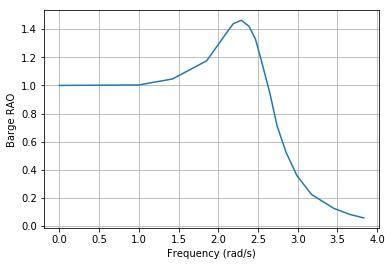

In [4]:
plt.figure()
plt.plot(omegaBarge,RAOBarge)
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Barge RAO')
plt.grid()
plt.show()

## Ship Transfer Function

If a ship's response to waves is linear and time-invariant, then ship motions can be predicted from the water elevation using the ship's Response Amplitude Operator (RAO).  The RAO is the ratio of wave height to heave motion as a function of frequency.  An example barge RAO is shown below from (Rodirquez et al 2016).  

In [5]:
interact(plot_func_wave_ship,period = wp, height = wh)

interactive(children=(IntSlider(value=7, description='Period (s):', layout=Layout(height='40px', width='35%'), max=10, min=1), IntSlider(value=7, description='Significant Wave Height (m):', layout=Layout(height='40px', width='45%'), max=10, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_func_wave_ship>

## Ship Motion as a Sensor

Ship motion passes the water elevation through with unity gain at low frequencies, amplifies it in a narrow frequency band at resonance, and attenuates at high frequencies.  As a result, the power spectral density of the wave motion closely matches that of the waves for seas with low modal frequency, but differs significantly for seas with modal frequency equal to or greater than the ship resonant frequency.  

The power spectral densities for waves and ship motions that result are plotted below for dominant periods of 3 s, 6s, and 9s.  At the low frequency (9s period) waves, the ship motion nearly matches the waves.  But, at the high frequency (3s period) waves, the ship response is significantly different from the waves.  Motion at the resonance frequency is amplified, and attenuated at higher frequencies.

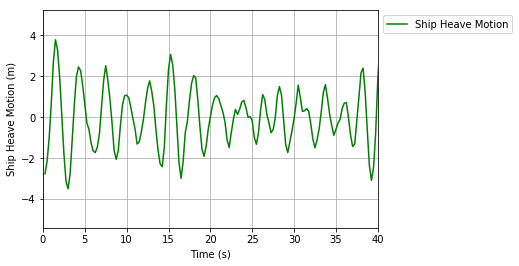

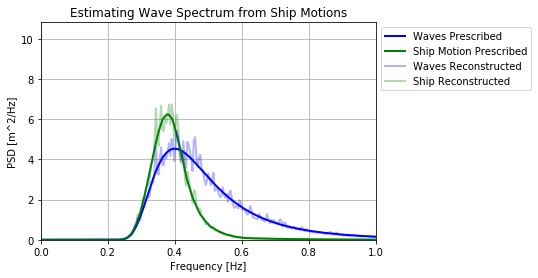

In [6]:
# Generate a random sea from a wave spectrum
n = 2**12
nw = 2**10
wMax = 20.
dw = wMax/nw
tMax = 2**10.

# Create a sample spectrum
w = [(wMax*x/nw) for x in range(1,nw)]  # frequencies (rad/s)
WaveSpectrum = BretSchneider(w,2.5,4.5)
ShipSpectrum = []
for j in range(len(w)):
    ShipSpectrum.append(WaveSpectrum[j]*np.interp(w[j],omegaBarge,RAOBarge))

# Create a ship heave motion time series realization
t = [(tMax*x/n) for x in range(1,n)]  # time (s)
ShipMotion = waveTimeSeries(t,ShipSpectrum,w,w[2]-w[1])

# Add white noise to model sensor noise
ShipMotionNoisy = []
for i in range(len(ShipMotion)):
    ShipMotionNoisy.append(ShipMotion[i] + np.random.normal(0,0.5))

# Plot the ship motion
plt.figure()
plt.plot(t,ShipMotion,color='green',label='Ship Heave Motion')
# plt.plot(t,ShipMotionNoisy,color='green',alpha=0.5,label='Measured Ship Heave Motion')
plt.xlabel('Time (s)')
plt.ylabel('Ship Heave Motion (m)')
plt.xlim([0,40])
plt.grid()
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left', ncol=1)
plt.show()

# Compute spectrum from time-series
fs = n/tMax
f, Pxx_ship = signal.welch(ShipMotion, fs, nperseg=n/4., window='hann')
Pxx_ship = [x/np.pi for x in Pxx_ship]
f, Pxx_shipNoisy = signal.welch(ShipMotionNoisy, fs, nperseg=n/4., window='hann')
Pxx_shipNoisy = [x/np.pi for x in Pxx_shipNoisy]

# Compute the reconstructed wave spectrum
Pxx_waves = []
Pxx_wavesNoisy = []
for i in range(len(f)):
    Pxx_waves.append(Pxx_ship[i]/np.interp(f[i],omegaBarge/(2*np.pi),RAOBarge))
    Pxx_wavesNoisy.append(Pxx_shipNoisy[i]/np.interp(f[i],omegaBarge/(2*np.pi),RAOBarge))

# Plot the spectra of the prescribed and reconstructed signals
plt.figure()
plt.title('Estimating Wave Spectrum from Ship Motions')
plt.plot([x/(2.*np.pi) for x in w],[x*(2*np.pi) for x in WaveSpectrum],'-',linewidth=2, color='blue',label='Waves Prescribed')
plt.plot([x/(2.*np.pi) for x in w],[x*(2*np.pi) for x in ShipSpectrum],'-',linewidth=2, color='green',label='Ship Motion Prescribed')
plt.plot(f, Pxx_waves, '-', color='blue', alpha = 0.3, linewidth = 2, label='Waves Reconstructed')
plt.plot(f, Pxx_ship, '-', color='green',alpha = 0.3, linewidth = 2, label='Ship Reconstructed')
plt.xlim([0,1])
plt.ylim([1e-3,2*np.max(Pxx_waves)])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [m^2/Hz]')
plt.grid()
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left', ncol=1)
plt.show()


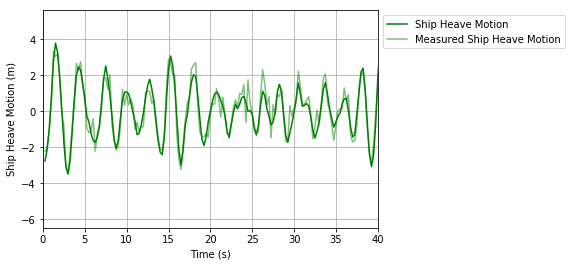

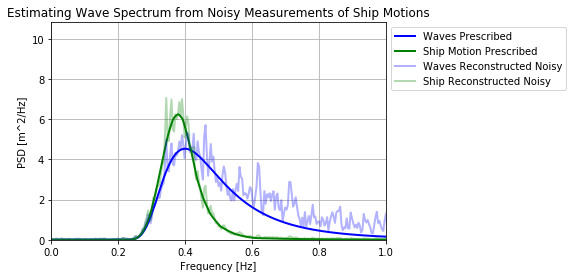

In [7]:
# Plot the ship motion
plt.figure()
plt.plot(t,ShipMotion,color='green',label='Ship Heave Motion')
plt.plot(t,ShipMotionNoisy,color='green',alpha=0.5,label='Measured Ship Heave Motion')
plt.xlabel('Time (s)')
plt.ylabel('Ship Heave Motion (m)')
plt.xlim([0,40])
plt.grid()
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left', ncol=1)
plt.show()

# Plot the spectra of the prescribed and reconstructed signals
plt.figure()
plt.title('Estimating Wave Spectrum from Noisy Measurements of Ship Motions')
plt.plot([x/(2.*np.pi) for x in w],[x*(2*np.pi) for x in WaveSpectrum],'-',linewidth=2, color='blue',label='Waves Prescribed')
plt.plot([x/(2.*np.pi) for x in w],[x*(2*np.pi) for x in ShipSpectrum],'-',linewidth=2, color='green',label='Ship Motion Prescribed')
plt.plot(f, Pxx_wavesNoisy, '-', color='blue', alpha = 0.3, linewidth = 2, label='Waves Reconstructed Noisy')
plt.plot(f, Pxx_shipNoisy, '-', color='green',alpha = 0.3, linewidth = 2, label='Ship Reconstructed Noisy')
plt.xlim([0,1])
plt.ylim([1e-3,2*np.max(Pxx_waves)])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [m^2/Hz]')
plt.grid()
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left', ncol=1)
plt.show()